# Fam inference

In [1]:
import collections
import math
import os
import re
import sys
from collections import OrderedDict
from functools import partial

import cv2
import numpy as np
import pandas as pd
import scipy as sp
import skimage
import skimage.io
import torch
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import cohen_kappa_score
from torch import nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn.modules.batchnorm import _BatchNorm
from torch.nn.parameter import Parameter
from torch.utils import model_zoo
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sys.path = [
    '../input/ttach-kaggle/ttach/',
] + sys.path
import ttach as tta

In [2]:
# Preprocess
############################################################################################

def get_tiles(img, tile_size, n_tiles, mode=0):
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
    pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

    img2 = np.pad(
        img,
        [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0, 0]],
        constant_values=255,
    )
    img3 = img2.reshape(
        img2.shape[0] // tile_size, tile_size, img2.shape[1] // tile_size, tile_size, 3
    )

    img3 = img3.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)
    n_tiles_with_info = (
        img3.reshape(img3.shape[0], -1).sum(1) < tile_size ** 2 * 3 * 255
    ).sum()
    if len(img3) < n_tiles:
        img3 = np.pad(
            img3,
            [[0, n_tiles - len(img3)], [0, 0], [0, 0], [0, 0]],
            constant_values=255,
        )
    idxs = np.argsort(img3.reshape(img3.shape[0], -1).sum(-1))[:n_tiles]
    img3 = img3[idxs]
    return img3, n_tiles_with_info >= n_tiles


def concat_tiles(tiles, tile_shape):
    image = cv2.hconcat([cv2.vconcat(tiles[ts]) for ts in tile_shape])
    return image

In [3]:
# Dataset
###################################################################

class TestDataset(Dataset):
    def __init__(
        self,
        df,
        image_dir,
        num_tile,
        img_size,
        tile_size_r,
        tile_size_k,
        tile_mode,
        transform,
    ):
        self.df = df
        self.img_ids = self.df.image_id
        self.image_dir = image_dir
        self.transform = transform
        self.num_tiles = num_tile
        self.img_size = img_size
        self.tile_mode = tile_mode
        self.tile_size_k = tile_size_k
        self.tile_size_r = tile_size_r

        self.is_karolinska = (self.df.data_provider == "karolinska").values
        self.tiff_level = 1
        n = int(self.num_tiles ** 0.5)
        self.tile_shape = np.array(range(self.num_tiles)).reshape((n, n))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.img_ids[idx]
        file_path = os.path.join(self.image_dir, f"{file_name}.tiff")

        # RGB
        img_tmp = skimage.io.MultiImage(file_path)[self.tiff_level]
        tiles, _ = get_tiles(
            img_tmp,
            tile_size=self.tile_size_k,
            n_tiles=self.num_tiles,
            mode=self.tile_mode,
        )

        tiles = np.array(tiles)
        image = concat_tiles(tiles, tile_shape=self.tile_shape)
        image = image.astype(np.float32)
        image = 255 - image  # this task images has many whites(255)
        image /= 255  # ToTensorV2 has no normalize !
#         image = cv2.resize(image, (self.img_size, self.img_size))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

In [4]:
# EfficientNet

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple(
    "GlobalParams",
    [
        "batch_norm_momentum",
        "batch_norm_epsilon",
        "dropout_rate",
        "num_classes",
        "width_coefficient",
        "depth_coefficient",
        "depth_divisor",
        "min_depth",
        "drop_connect_rate",
        "image_size",
    ],
)

# Parameters for an individual model block
BlockArgs = collections.namedtuple(
    "BlockArgs",
    [
        "kernel_size",
        "num_repeat",
        "input_filters",
        "output_filters",
        "expand_ratio",
        "id_skip",
        "stride",
        "se_ratio",
    ],
)

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training:
        return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand(
        [batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device
    )
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        dilation=1,
        groups=1,
        bias=True,
    ):
        super().__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias
        )
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(
        self, in_channels, out_channels, kernel_size, image_size=None, **kwargs
    ):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d(
                (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
            )
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        return x


class Identity(nn.Module):
    def __init__(self,):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


In [5]:
########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        "efficientnet-b0": (1.0, 1.0, 224, 0.2),
        "efficientnet-b1": (1.0, 1.1, 240, 0.2),
        "efficientnet-b2": (1.1, 1.2, 260, 0.3),
        "efficientnet-b3": (1.2, 1.4, 300, 0.3),
        "efficientnet-b4": (1.4, 1.8, 380, 0.4),
        "efficientnet-b5": (1.6, 2.2, 456, 0.4),
        "efficientnet-b6": (1.8, 2.6, 528, 0.5),
        "efficientnet-b7": (2.0, 3.1, 600, 0.5),
        "efficientnet-b8": (2.2, 3.6, 672, 0.5),
        "efficientnet-l2": (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split("_")
        options = {}
        for op in ops:
            splits = re.split(r"(\d.*)", op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert ("s" in options and len(options["s"]) == 1) or (
            len(options["s"]) == 2 and options["s"][0] == options["s"][1]
        )

        return BlockArgs(
            kernel_size=int(options["k"]),
            num_repeat=int(options["r"]),
            input_filters=int(options["i"]),
            output_filters=int(options["o"]),
            expand_ratio=int(options["e"]),
            id_skip=("noskip" not in block_string),
            se_ratio=float(options["se"]) if "se" in options else None,
            stride=[int(options["s"][0])],
        )

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            "r%d" % block.num_repeat,
            "k%d" % block.kernel_size,
            "s%d%d" % (block.strides[0], block.strides[1]),
            "e%s" % block.expand_ratio,
            "i%d" % block.input_filters,
            "o%d" % block.output_filters,
        ]
        if 0 < block.se_ratio <= 1:
            args.append("se%s" % block.se_ratio)
        if block.id_skip is False:
            args.append("noskip")
        return "_".join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.

        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.

        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(
    width_coefficient=None,
    depth_coefficient=None,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    image_size=None,
    num_classes=1000,
):
    """ Creates a efficientnet model. """

    blocks_args = [
        "r1_k3_s11_e1_i32_o16_se0.25",
        "r2_k3_s22_e6_i16_o24_se0.25",
        "r2_k5_s22_e6_i24_o40_se0.25",
        "r3_k3_s22_e6_i40_o80_se0.25",
        "r3_k5_s11_e6_i80_o112_se0.25",
        "r4_k5_s22_e6_i112_o192_se0.25",
        "r1_k3_s11_e6_i192_o320_se0.25",
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith("efficientnet"):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s
        )
    else:
        raise NotImplementedError("model name is not pre-defined: %s" % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {"no-url"}
url_map_advprop = {"no-url"}


def load_pretrained_weights(model, model_name, load_fc=True, advprop=False):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    # AutoAugment or Advprop (different preprocessing)
    url_map_ = url_map_advprop if advprop else url_map
    state_dict = model_zoo.load_url(url_map_[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop("_fc.weight")
        state_dict.pop("_fc.bias")
        res = model.load_state_dict(state_dict, strict=False)
        assert set(res.missing_keys) == set(
            ["_fc.weight", "_fc.bias"]
        ), "issue loading pretrained weights"
    print("Loaded pretrained weights for {}".format(model_name))


class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block

    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above

    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (
            0 < self._block_args.se_ratio <= 1
        )
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = (
            self._block_args.input_filters * self._block_args.expand_ratio
        )  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(
                in_channels=inp, out_channels=oup, kernel_size=1, bias=False
            )
            self._bn0 = nn.BatchNorm2d(
                num_features=oup, momentum=self._bn_mom, eps=self._bn_eps
            )

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup,
            out_channels=oup,
            groups=oup,  # groups makes it depthwise
            kernel_size=k,
            stride=s,
            bias=False,
        )
        self._bn1 = nn.BatchNorm2d(
            num_features=oup, momentum=self._bn_mom, eps=self._bn_eps
        )

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(
                1, int(self._block_args.input_filters * self._block_args.se_ratio)
            )
            self._se_reduce = Conv2d(
                in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1
            )
            self._se_expand = Conv2d(
                in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1
            )

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(
            in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False
        )
        self._bn2 = nn.BatchNorm2d(
            num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps
        )
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = (
            self._block_args.input_filters,
            self._block_args.output_filters,
        )
        if (
            self.id_skip
            and self._block_args.stride == 1
            and input_filters == output_filters
        ):
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()



In [6]:
class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods

    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks

    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')

    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), "blocks_args should be a list"
        assert len(blocks_args) > 0, "block args must be greater than 0"
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(
            32, self._global_params
        )  # number of output channels
        self._conv_stem = Conv2d(
            in_channels, out_channels, kernel_size=3, stride=2, bias=False
        )
        self._bn0 = nn.BatchNorm2d(
            num_features=out_channels, momentum=bn_mom, eps=bn_eps
        )

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(
                    block_args.input_filters, self._global_params
                ),
                output_filters=round_filters(
                    block_args.output_filters, self._global_params
                ),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params),
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(
                    input_filters=block_args.output_filters, stride=1
                )
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(
            num_features=out_channels, momentum=bn_mom, eps=bn_eps
        )

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
        x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(
        cls, model_name, advprop=False, num_classes=1000, in_channels=3
    ):
        model = cls.from_name(model_name, override_params={"num_classes": num_classes})
        load_pretrained_weights(
            model, model_name, load_fc=(num_classes == 1000), advprop=advprop
        )
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size=model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(
                in_channels, out_channels, kernel_size=3, stride=2, bias=False
            )
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """ Validates model name. """
        valid_models = ["efficientnet-b" + str(i) for i in range(9)]
        if model_name not in valid_models:
            raise ValueError("model_name should be one of: " + ", ".join(valid_models))


class CustomEfficientNet(nn.Module):
    def __init__(
        self,
        base="efficientnet-b0",
        pool_type="gem",
        in_ch=3,
        out_ch=1,
        pretrained=False,
    ):
        super(CustomEfficientNet, self).__init__()
        assert base in {
            "efficientnet-b0",
            "efficientnet-b1",
            "efficientnet-b2",
            "efficientnet-b3",
            "efficientnet-b4",
        }
        assert pool_type in {"concat", "avg", "gem"}

        self.base = base
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.pretrained = pretrained

        if pretrained:
            self.net = EfficientNet.from_pretrained(base)
        else:
            self.net = EfficientNet.from_name(base)

        out_shape = self.net._fc.in_features
        if pool_type == "concat":
            self.net._avg_pooling = AdaptiveConcatPool2d()
            out_shape = out_shape * 2
        elif pool_type == "gem":
            self.net._avg_pooling = GeM()
            out_shape = out_shape
        self.net._fc = nn.Sequential(
            Flatten(), SEBlock(out_shape), nn.Dropout(), nn.Linear(out_shape, out_ch)
        )

    def forward(self, x):
        x = self.net(x)
        return x


class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)


class SEBlock(nn.Module):
    def __init__(self, in_ch, r=8):
        super(SEBlock, self).__init__()

        self.linear_1 = nn.Linear(in_ch, in_ch // r)
        self.linear_2 = nn.Linear(in_ch // r, in_ch)

    def forward(self, x):
        input_x = x

        x = F.relu(self.linear_1(x), inplace=True)
        x = self.linear_2(x)
        x = torch.sigmoid(x)

        x = input_x * x

        return x


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1.0 / p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return (
            self.__class__.__name__
            + f"(p={self.p.data.tolist()[0]:.4f}, eps={str(self.eps)})"
        )


######### Inference
#################################################################
def inference(
    dataloader, model, device, out_ch, tta=False, fp16=False, dataloader2=None,
):
    probs = []

    def extract_preds(logits_tmp):
        if out_ch == 1:
            preds_tmp = logits_tmp
        elif out_ch == 5:
            preds_tmp = logits_tmp.sigmoid().sum(1)
        elif out_ch > 5:
            preds_tmp = logits_tmp[:, :5].sigmoid()
            preds_tmp = preds_tmp.sum(1)
        return preds_tmp.detach()

    for i, images in tqdm(enumerate(dataloader), total=len(dataloader)):
        if fp16:
            images = images.half()
        images = images.to(device)

        with torch.no_grad():
            logits = model(images)
            preds = extract_preds(logits)

            if tta:
                logits_hflip = model(images.flip(3))
                preds_hflip = extract_preds(logits_hflip)
                preds = (preds + preds_hflip) / 2.0
        probs.append(preds.to("cpu").numpy())
    probs = np.concatenate(probs)

    if dataloader2 is not None:
        probs2 = inference(
            dataloader2, model, device, out_ch, tta, fp16=fp16, dataloader2=None
        )
        return (probs + probs2) / 2.0, probs
    return probs


def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights="quadratic")


class MyOptimizedRounder:
    def __init__(self):
        self.coef = None
        self.initial_coef = np.array([0.5, 1.5, 2.5, 3.5, 4.5])

    def judge_each_thres(self, thres, x):
        tmp = thres.reshape((1, -1)) <= x.reshape((-1, 1))
        result = tmp.sum(axis=1)
        return result

    def _kappa_loss(self, coef, x, y):
        x_p = self.judge_each_thres(coef, np.copy(x))
        ll = quadratic_weighted_kappa(y, x_p)
        return -ll

    def fit(self, x, y):
        loss_partial = partial(self._kappa_loss, x=x, y=y)
        self.coef = sp.optimize.minimize(
            loss_partial, self.initial_coef, method="nelder-mead"
        )

    def predict(self, x, coef=None):
        if coef is None:
            coef = self.coef["x"]
        return self.judge_each_thres(coef, np.copy(x))

    def predict_default_thres(self, x):
        coef = self.initial_coef.copy()
        return self.judge_each_thres(coef, np.copy(x))

    def coefficients(self):
        return self.coef["x"]


# main
#################################################################


def print_eval_local(df, preds):
    ground_truth = df.isup_grade.values
    score = quadratic_weighted_kappa(ground_truth, preds)
    print(f"Local CV kappa score(all): {score}")

    indx_val_karolinska = df.data_provider == "karolinska"
    indx_val_radboud = df.data_provider == "radboud"
    indx = indx_val_karolinska

    v_acc_k = (preds[indx] == ground_truth[indx]).mean() * 100.0
    v_kappa_k = quadratic_weighted_kappa(ground_truth[indx], preds[indx])
    print(f"Local CV kappa score(karolinska): {v_kappa_k}")
    print(f"Local CV accuracy(karolinska): {v_acc_k}")
    indx = indx_val_radboud
    v_acc_r = (preds[indx] == ground_truth[indx]).mean() * 100.0
    v_kappa_r = quadratic_weighted_kappa(ground_truth[indx], preds[indx])
    print(f"Local CV kappa score(radboud): {v_kappa_r}")
    print(f"Local CV accuracy(radboud): {v_acc_r}")


In [7]:
class Config:
    def __init__(self, on_kernel=True, kfold=1, debug=False):
        self.on_kernel = on_kernel
        self.num_tile = 64
        self.tile_size_k = 192
        self.tile_size_r = 192
        self.img_size = 1536
        self.fp16 = False
        self.batch_size = 4
        if self.fp16:
            self.batch_size = int(self.batch_size * 2)
        self.tta = False
        self.ada_bn = False  # public lb 0.67 if True and fp16 is True

        # Model config
        self.in_ch = 3
        self.out_ch = 10
        self.base = "efficientnet-b1"

        # pseudo label config
        self.pseudo_use_threshold = 0.2
        self.pseudo_soft_label = False

        # weight config
#         self.weight_name = "097_efficientnet-b1_kfold_{}_latest.pt"
        self.weight_name = "final_2_efficientnet-b1_kfold_{}_latest.pt"
        self.weight_name = self.weight_name.format(kfold)

        if on_kernel:
            # Image folder
            self.data_dir = "../input/prostate-cancer-grade-assessment"
            test_image_folder = os.path.join(self.data_dir, "test_images")
            train_image_folder = os.path.join(self.data_dir, "train_images")
            is_test = os.path.exists(test_image_folder)
            self.image_folder = test_image_folder if is_test else train_image_folder

            df_train = pd.read_csv(os.path.join(self.data_dir, "train.csv"))
            sample = pd.read_csv(os.path.join(self.data_dir, "test.csv"))
            self.df = sample if is_test else df_train.loc[:16]
        else:
            # Local PC
            self.data_dir = "../input"
            self.image_folder = "../input/train_images"
            df = pd.read_csv("../input/train-5kfold.csv")
            self.kfold = 1
            self.df = df[df["kfold"] == self.kfold].reset_index(drop=True)
            if debug:
                self.df = self.df[:16].reset_index(drop=True)

    def get_weight_path(self):
        if self.on_kernel:
            return os.path.join("../input/030-weight", self.weight_name)
        else:
            dir_name = self.weight_name.split("_")[0]
            return os.path.join("../output/model", dir_name, self.weight_name)

    def get_args_ds(self):
        return {
            "df": self.df,
            "image_dir": self.image_folder,
            "num_tile": self.num_tile,
            "img_size": self.img_size,
            "tile_size_k": self.tile_size_k,
            "tile_size_r": self.tile_size_r,
            "transform": Compose([ToTensorV2()]),
        }

    def get_args_dl(self):
        return {"batch_size": self.batch_size, "shuffle": False, "num_workers": 4}


def get_model(cfg_model):
    net = None
    if "seresnext" in cfg_model.base:
        net = CustomSEResNeXt(
            in_ch=cfg_model.in_ch,
            out_ch=cfg_model.out_ch,
            pool_type="gem",
            pretrained=False,
        )
    elif "efficientnet" in cfg_model.base:
        net = CustomEfficientNet(
            base=cfg_model.base,
            in_ch=cfg_model.in_ch,
            out_ch=cfg_model.out_ch,
            pretrained=False,
        )
    assert net is not None
    return net


def inference_from_cfg(cfg, model=None):
    print("Make frame and path")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Make Dataloader
    test_dataset = TestDataset(tile_mode=0, **cfg.get_args_ds())
    test_loader = DataLoader(test_dataset, **cfg.get_args_dl())
    test_dataset2 = TestDataset(tile_mode=2, **cfg.get_args_ds())
    test_loader2 = DataLoader(test_dataset2, **cfg.get_args_dl())
    print("Make data loader")

    if model is not None:
        print(f"Use existed Model: {cfg.base}")
    else:
        print(f"Get Model: {cfg.base}")
        model = get_model(cfg)
        w_path = cfg.get_weight_path()
        print(f"Load weight...: {w_path}")
        state_dict = torch.load(w_path)["state_dict"]
        state_dict = {k[4:]: v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)

    if cfg.ada_bn:
        # Apply AdaBN
        for m in model.modules():
            if isinstance(m, _BatchNorm):
                m.track_running_stats = False

    if cfg.fp16:
        model = model.half()
    model.eval()

    model = model.to(device)
    
    transforms = tta.Compose(
        [tta.HorizontalFlip(), tta.VerticalFlip(), tta.Rotate90(angles=[0, 90, 180])]
    )
    model = tta.ClassificationTTAWrapper(model, transforms)

    # Inference and round
    print("Inference start")
    probs, probs_without_tta = inference(
        test_loader,
        model,
        device,
        out_ch=cfg.out_ch,
        tta=cfg.tta,
        fp16=cfg.fp16,
        dataloader2=test_loader2,
    )
    return probs, probs_without_tta


def inference_mean_cfgs(cfgs):
    probs_all = None
    probs_without_tta_all = None
    for c in cfgs:
        probs, probs_without_tta = inference_from_cfg(c)
        if probs_all is None:
            probs_all = probs
            probs_without_tta_all = probs_without_tta
        else:
            probs_all = probs_all + probs
            probs_without_tta_all = probs_without_tta_all + probs_without_tta
    probs = probs_all / float(len(cfgs))
    probs_without_tta = probs_without_tta_all / float(len(cfgs))
    return probs, probs_without_tta


def main(on_kernel=False, debug=False):
    cfgs = [Config(on_kernel=on_kernel, kfold=k, debug=debug) for k in [1, 4, 5]]
    probs_raw, probs_without_tta_raw = inference_mean_cfgs(cfgs)

    print("Round predicts")
    rounder = MyOptimizedRounder()
    preds = rounder.predict_default_thres(probs_raw)
    preds_without_tta = rounder.predict_default_thres(probs_without_tta_raw)

    # Save or eval on local
    if on_kernel:
        df = cfgs[0].df[["image_id"]].copy()
        df["probs_raw"] = probs_raw
        df["isup_grade"] = preds
        df["isup_grade"] = df["isup_grade"].astype(int)
        return df
    else:
        print(f"\n*** Normal preds results ***")
        print_eval_local(cfgs[0].df, preds_without_tta)
        print(f"\n*** Mode TTA preds results ***")
        print_eval_local(cfgs[0].df, preds)

        df = cfgs[0].df
        df["probs_raw"] = probs_raw
        df["probs_without_tta_raw"] = probs_without_tta_raw
        df["preds"] = preds
        df["preds_without_tta"] = preds_without_tta
        df.to_csv(f"local_preds_{cfgs[0].weight_name.split('.')[0]}.csv", index=False)


In [8]:
df_tmp = main(on_kernel=True, debug=False)

Make frame and path
Make data loader
Get Model: efficientnet-b1
Load weight...: ../input/030-weight/final_2_efficientnet-b1_kfold_1_latest.pt
Inference start


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Make frame and path
Make data loader
Get Model: efficientnet-b1
Load weight...: ../input/030-weight/final_2_efficientnet-b1_kfold_4_latest.pt
Inference start


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Make frame and path
Make data loader
Get Model: efficientnet-b1
Load weight...: ../input/030-weight/final_2_efficientnet-b1_kfold_5_latest.pt
Inference start


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]

Round predicts


## part 2

In [9]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [10]:
sys.path = [
    '../input/ttach-kaggle/ttach/',
] + sys.path
import ttach as tta

In [11]:
import skimage.io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import model as enet

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [12]:
data_dir = '../input/prostate-cancer-grade-assessment'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

model_dir = '../input/panda-public-models'
image_folder = os.path.join(data_dir, 'test_images')
is_test = os.path.exists(image_folder)  # IF test_images is not exists, we will use some train images.
image_folder = image_folder if is_test else os.path.join(data_dir, 'train_images')

df = df_test if is_test else df_train.loc[:16]

tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 4
num_workers = 4

device = torch.device('cuda')

print(image_folder)

../input/prostate-cancer-grade-assessment/train_images


In [13]:
class enetv3(nn.Module):
    def __init__(self, modelname, out_dim=5, freeze_bn=True):
        super(enetv3, self).__init__()
        if "resnet" in modelname or "resnext" in modelname:
            basemodel = resnet.__dict__[modelname](
                                    pretrained=True)
        if modelname == "rx50":
            basemodel = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext50_32x4d_ssl')
                            
        if "eff" in modelname:
            from efficientnet_pytorch import EfficientNet
            self.basemodel = EfficientNet.from_name(modelname) 
            self.myfc = nn.Linear(self.basemodel._fc.in_features, out_dim)
            self.basemodel._fc = nn.Identity()     
            self.basemodel._avg_pooling = nn.AdaptiveAvgPool2d(1) #GeM() 
        else:
            fcs = basemodel.fc.state_dict()["weight"].shape[1]
            self.basemodel = nn.Sequential(*list(basemodel.children())[:-2])
            if poolmethod=="maxpool":
                self.pool = nn.AdaptiveMaxPool2d(1)
            else:
                self.pool = nn.AdaptiveAvgPool2d(1)
            self.myfc = nn.Linear(fcs, out_dim)
            
    def extract(self, x):
        return self.basemodel(x)

    def forward(self, x):
        x = self.basemodel(x)
        if not "eff" in modelname:
            x = self.pool(x).squeeze(2).squeeze(2)
            x = self.myfc(x)
        else:
            x = self.myfc(x)
        return x
    
def load_models(model_files):
    models = []
    for model_f in model_files:
        #model_f = os.path.join("../input/panda-models", model_f)
        model_f = os.path.join("../input/latesubspanda", model_f)
        if "res" in model_f:
            model = enetv2(out_dim=5)
        elif "eff" in model_f:
            model = enetv3(modelname, out_dim=5)
        model.load_state_dict(torch.load(model_f))
        model.eval()
        model.to(device)
        models.append(model)
        print(f'{model_f} loaded!')
    return models

modelname="efficientnet-b0"
model_files = [
    'efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold0.pth',
]

model_files2 = [
    'efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold0.pth',
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold1.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold2.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold3.pth",
    "efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold4.pth"
]

models2 = load_models(model_files2)
models = load_models(model_files)

../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold0.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold1.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold2.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold3.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold4.pth loaded!
../input/latesubspanda/efficientnet-b0famlabelsmodelsub_avgpool_tile36_imsize256_mixup_final_epoch20_fold0.pth loaded!


In [14]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img) < n_tiles:
            img3 = np.pad(img3,[[0,N-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 sub_imgs=False
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.sub_imgs = sub_imgs

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1][:,:,::-1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        idxes = np.asarray(idxes) + self.n_tiles if self.sub_imgs else idxes

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        #images = 255 - images
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        return torch.tensor(images)

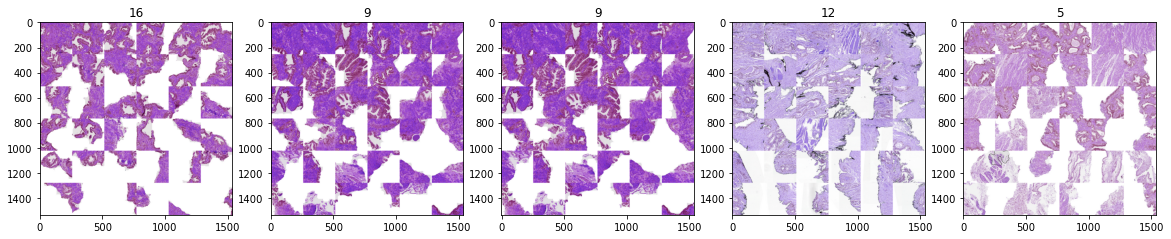

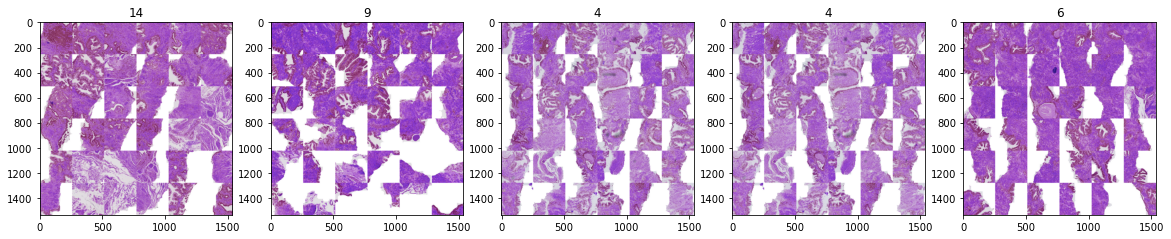

In [15]:
if not is_test:
    dataset_show = PANDADataset(df, image_size, n_tiles, 4)
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img = dataset_show[idx]
            axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
            axarr[p].set_title(str(idx))

In [16]:
dataset = PANDADataset(df, image_size, n_tiles, 0)  # mode == 0
loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

dataset2 = PANDADataset(df, image_size, n_tiles, 2)  # mode == 2
loader2 = DataLoader(dataset2, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [17]:
import ttach as tta
if len(dataset) > 50:
    transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
            tta.Rotate90(angles=[0, 90, 180]),

        ]
    )
else:
    transforms = tta.Compose(
        [
            #tta.HorizontalFlip(),
        ]
    )
tta_models = []
tta_models2 = []
for model in models:
    tta_models.append(tta.ClassificationTTAWrapper(model, transforms))
for model in models2:
    tta_models2.append(tta.ClassificationTTAWrapper(model, transforms))

In [18]:
LOGITS = []
LOGITS2 = []
LOGITS12 = []
LOGITS22 = []

with torch.no_grad():
    for data in tqdm(loader):
        data = data.to(device)
        for tta_model in tta_models:
            logits = tta_model(data)
        LOGITS.append(logits)
        
        for i, tta_model in enumerate(tta_models2):
            if i == 0:
                logits = tta_model(data).sigmoid()
            else:
                logits = logits + tta_model(data).sigmoid()
        LOGITS2.append(logits/5)
        
    for data in tqdm(loader2):
        data = data.to(device)
        for tta_model in tta_models:
            logits = tta_model(data)
        LOGITS12.append(logits)
        
        for i, tta_model in enumerate(tta_models2):
            if i == 0:
                logits = tta_model(data).sigmoid()
            else:
                logits = logits + tta_model(data).sigmoid()
        LOGITS22.append(logits/5)


LOGITS = (torch.cat(LOGITS).sigmoid().cpu() + torch.cat(LOGITS2).cpu()
         +torch.cat(LOGITS12).sigmoid().cpu() + torch.cat(LOGITS22).cpu()) / 4

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [19]:
PREDS = LOGITS.sum(1).numpy()
df['isup_grade'] = PREDS
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0.032017,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0.018519,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4.025021,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4.138853,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0.039004,0+0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0.162166,0+0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1.023952,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1.341965,3+3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1.013243,3+3
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1.015524,3+3


In [20]:
df_tmp.rename({'probs_raw': 'part_1_pred'}, axis=1, inplace=True)

In [21]:
df = df.merge(df_tmp[['image_id', 'part_1_pred']], on = 'image_id', how = 'left')

In [22]:
# aru fam, 0.5:0.5
p_w = 0.5
df['isup_grade'] = df['isup_grade'] * p_w +  df['part_1_pred'] * (1-p_w)

In [23]:
df['isup_grade'] = df['isup_grade'].apply(lambda x: int(np.round(x)))

In [24]:
df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
print(df.head())
print()
print(df.isup_grade.value_counts())

                           image_id data_provider  isup_grade gleason_score  \
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0   
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0   
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4   
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4   
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0   

   part_1_pred  
0     0.010458  
1     0.011963  
2     4.870091  
3     4.481043  
4     0.005340  

1    8
0    6
4    2
2    1
Name: isup_grade, dtype: int64


In [25]:
df.head(20)

,image_id,data_provider,isup_grade,gleason_score,part_1_pred
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0.010458
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0.011963
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,4.870091
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4.481043
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0.005340
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,0.498580
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,1.093211
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3,1.395936
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3,1.072245
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3,1.030664
